In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv")

In [3]:
test = pd.read_csv("test.csv")

In [4]:
train.dropna(how='any', axis=0, inplace = True)

In [5]:
train.shape

(55423480, 8)

In [6]:
train=train[(train.fare_amount > 0) & (train.fare_amount <= 475)]

In [7]:
train.shape

(55419564, 8)

In [8]:
train=train[(train.pickup_longitude > -80) & (train.pickup_longitude < -70)]

In [9]:
train=train[(train.pickup_latitude > 35) & (train.pickup_latitude < 45)]

In [10]:
train=train[(train.dropoff_longitude > -80) & (train.dropoff_longitude < -70)]

In [11]:
train=train[(train.dropoff_latitude > 35) & (train.dropoff_latitude < 45)]

In [12]:
train.shape

(54269340, 8)

In [13]:
train=train[(train.passenger_count > 0 ) & (train.passenger_count < 10)]

In [14]:
train.shape

(54078484, 8)

In [15]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [16]:
def prepare_distance_features(df):
    df['pickup_latitude'] = np.radians(df['pickup_latitude'])
    df['dropoff_latitude'] = np.radians(df['dropoff_latitude'])
    df['pickup_longitude'] = np.radians(df['pickup_longitude'])
    df['dropoff_longitude'] = np.radians(df['dropoff_longitude'])
    # manhattan distance
    df['longitude_distance'] = abs(df['pickup_longitude'] - df['dropoff_longitude'])
    df['latitude_distance'] = abs(df['pickup_latitude'] - df['dropoff_latitude'])
    df['manhattan'] = np.abs(df['dropoff_latitude'] - df['pickup_latitude']) +\
    np.abs(df['dropoff_longitude'] - df['pickup_longitude'])
    # Straight distance
    df['distance_travelled'] = (df['longitude_distance'] ** 2 + df['latitude_distance'] ** 2) ** .5
    df['distance_travelled_sin'] = np.sin((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** .5)
    df['distance_travelled_cos'] = np.cos((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** .5)
    df['distance_travelled_sin_sqrd'] = np.sin((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** .5) ** 2
    df['distance_travelled_cos_sqrd'] = np.cos((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** .5) ** 2
    # Haversine formula for distance
    # Haversine formula:a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    R = 6371
    df['phi_chg'] = df['pickup_latitude'] - df['dropoff_latitude']
    df['delta_chg'] = df['pickup_longitude'] - df['dropoff_longitude']
    df['a'] = np.sin(df['phi_chg'] / 2)*np.sin(df['phi_chg'] / 2) + \
    np.cos(df['pickup_latitude']) * np.cos(df['dropoff_latitude']) * np.sin(df['delta_chg'] / 2)*np.sin(df['delta_chg'] / 2)
    df['haversine'] = R * 2 * np.arctan2(df.a ** .5, (1-df.a) ** .5)

    # Bearing
    # Formula:θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ )
    df['bearing'] = np.arctan2(np.sin(df['delta_chg']) * np.cos(df['dropoff_latitude']), np.cos(df['pickup_latitude']) * np.sin(df['dropoff_latitude']) - np.sin(df['pickup_latitude']) * np.cos(df['dropoff_latitude']) * np.cos(df['delta_chg']))
    return df

In [17]:
train = prepare_distance_features(train)
test = prepare_distance_features(test)

In [18]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,longitude_distance,latitude_distance,...,distance_travelled,distance_travelled_sin,distance_travelled_cos,distance_travelled_sin_sqrd,distance_travelled_cos_sqrd,phi_chg,delta_chg,a,haversine,bearing
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-1.288826,0.710721,-1.288779,0.710563,1,0.000047,0.000158,...,0.000165,7.438678e-09,1.0,5.533394e-17,1.0,0.000158,-0.000047,6.543999e-09,1.030764,-2.918897
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-1.291824,0.710546,-1.291182,0.711780,1,0.000642,0.001234,...,0.001391,7.921219e-07,1.0,6.274571e-13,1.0,-0.001234,-0.000642,4.397966e-07,8.450134,-0.375217
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-1.291242,0.711418,-1.291391,0.711231,2,0.000148,0.000187,...,0.000239,2.773872e-08,1.0,7.694363e-16,1.0,0.000187,0.000148,1.189208e-08,1.389525,2.599961
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-1.291319,0.710927,-1.291396,0.711363,1,0.000077,0.000435,...,0.000442,3.372076e-08,1.0,1.137089e-15,1.0,-0.000435,0.000077,4.826301e-08,2.799270,0.133905
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-1.290987,0.711536,-1.290787,0.711811,1,0.000200,0.000275,...,0.000340,5.489991e-08,1.0,3.014000e-15,1.0,-0.000275,-0.000200,2.461606e-08,1.999157,-0.502703


In [19]:
def prepare_time_features(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.replace(" UTC", "")
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    df['hour_of_day'] = df.pickup_datetime.dt.hour
    df['month'] = df.pickup_datetime.dt.month
    df["year"] = df.pickup_datetime.dt.year
    df["weekday"] = df.pickup_datetime.dt.weekday
    df["day_of_month"] = df.pickup_datetime.dt.day
    return df

In [20]:
train = prepare_time_features(train)
test = prepare_time_features(test)

In [21]:
def manhattan_dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):  
    distance = np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)
    return distance
def Haversine_dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    R = 6371
    phi_chg = pickup_lat - dropoff_lat
    delta_chg = pickup_long - dropoff_long
    a = np.sin(phi_chg/ 2)*np.sin(phi_chg / 2) + \
    np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(delta_chg / 2)*np.sin(delta_chg / 2)
    distance = R * 2 * np.arctan2(a ** .5, (1-a) ** .5)
    return distance

In [22]:
def transform(df):
    # Distances to nearby airports
    jfk_coord_lat = np.radians(40.639722)
    jfk_coord_long = np.radians(-73.778889)
    ewr_coord_lat = np.radians(40.6925)
    ewr_coord_long = np.radians(-74.168611)
    lga_coord_lat = np.radians(40.77725)
    lga_coord_long =np.radians(-73.872611)
    liberty_statue_lat = np.radians(40.6892)
    liberty_statue_long = np.radians(-74.0445)
    nyc_lat = np.radians(40.7141667)
    nyc_long = np.radians(-74.0063889)

    df['JFK_dist1'] = manhattan_dist(df.pickup_latitude, df.pickup_longitude, jfk_coord_lat, jfk_coord_long) + \
    manhattan_dist(jfk_coord_lat, jfk_coord_long, df.dropoff_latitude, df.dropoff_longitude)
    df['EWR_dist1'] = manhattan_dist(df.pickup_latitude, df.pickup_longitude, ewr_coord_lat, ewr_coord_long) +\
    manhattan_dist(ewr_coord_lat, ewr_coord_long, df.dropoff_latitude, df.dropoff_longitude)
    df['lga_dist1'] = manhattan_dist(df.pickup_latitude, df.pickup_longitude, lga_coord_lat, lga_coord_long) +\
    manhattan_dist(lga_coord_lat, lga_coord_long, df.dropoff_latitude, df.dropoff_longitude) 
    df['sol_dist1'] = manhattan_dist(df.pickup_latitude, df.pickup_longitude, liberty_statue_lat, liberty_statue_long) +\
    manhattan_dist(liberty_statue_lat, liberty_statue_long, df.dropoff_latitude, df.dropoff_longitude)
    df['nyc_dist1'] = manhattan_dist(df.pickup_latitude, df.pickup_longitude, nyc_lat, nyc_long) + \
    manhattan_dist(nyc_lat, nyc_long, df.dropoff_latitude, df.dropoff_longitude)
    df['JFK_dist2'] = Haversine_dist(df.pickup_latitude, df.pickup_longitude, jfk_coord_lat, jfk_coord_long) + \
    Haversine_dist(jfk_coord_lat, jfk_coord_long, df.dropoff_latitude, df.dropoff_longitude)
    df['EWR_dist2'] = Haversine_dist(df.pickup_latitude, df.pickup_longitude, ewr_coord_lat, ewr_coord_long) +\
    Haversine_dist(ewr_coord_lat, ewr_coord_long, df.dropoff_latitude, df.dropoff_longitude)
    df['lga_dist2'] = Haversine_dist(df.pickup_latitude, df.pickup_longitude, lga_coord_lat, lga_coord_long) +\
    Haversine_dist(lga_coord_lat, lga_coord_long, df.dropoff_latitude, df.dropoff_longitude) 
    df['sol_dist2'] = Haversine_dist(df.pickup_latitude, df.pickup_longitude, liberty_statue_lat, liberty_statue_long) +\
    Haversine_dist(liberty_statue_lat, liberty_statue_long, df.dropoff_latitude, df.dropoff_longitude)
    df['nyc_dist2'] = Haversine_dist(df.pickup_latitude, df.pickup_longitude, nyc_lat, nyc_long) + \
    Haversine_dist(nyc_lat, nyc_long, df.dropoff_latitude, df.dropoff_longitude)
    return df

In [23]:
train = transform(train)
test = transform(test)

In [24]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,longitude_distance,latitude_distance,...,JFK_dist1,EWR_dist1,lga_dist1,sol_dist1,nyc_dist1,JFK_dist2,EWR_dist2,lga_dist2,sol_dist2,nyc_dist2
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-1.288826,0.710721,-1.288779,0.710563,1,0.000047,0.000158,...,0.004927,0.012216,0.003145,0.007998,0.005863,20.265840,55.176046,14.342611,34.543548,27.572573
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-1.291824,0.710546,-1.291182,0.711780,1,0.000642,0.001234,...,0.011369,0.007858,0.005599,0.003641,0.001876,44.667679,31.832358,23.130775,15.125872,8.755732
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-1.291242,0.711418,-1.291391,0.711231,2,0.000148,0.000187,...,0.011320,0.008553,0.004737,0.004336,0.002134,43.597686,33.712082,19.865289,17.722624,9.847344
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-1.291319,0.710927,-1.291396,0.711363,1,0.000077,0.000435,...,0.011043,0.008112,0.005179,0.003894,0.001693,42.642965,32.556289,21.063132,15.738963,7.703421
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-1.290987,0.711536,-1.290787,0.711811,1,0.000200,0.000275,...,0.011158,0.010110,0.003408,0.005893,0.003691,43.329953,39.406828,15.219339,23.732406,15.600745


In [25]:
train.dtypes

key                                    object
fare_amount                           float64
pickup_datetime                datetime64[ns]
pickup_longitude                      float64
pickup_latitude                       float64
dropoff_longitude                     float64
dropoff_latitude                      float64
passenger_count                         int64
longitude_distance                    float64
latitude_distance                     float64
manhattan                             float64
distance_travelled                    float64
distance_travelled_sin                float64
distance_travelled_cos                float64
distance_travelled_sin_sqrd           float64
distance_travelled_cos_sqrd           float64
phi_chg                               float64
delta_chg                             float64
a                                     float64
haversine                             float64
bearing                               float64
hour_of_day                       

In [26]:
train.to_csv('train_model_AllDistance.csv', index=False)

In [27]:
test.to_csv('test_model_AllDistance.csv', index=False)

In [28]:
train= train.sample(n=10000000) 

In [29]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import gc

In [30]:
feats = [f for f in train.columns if f not in ['key','pickup_datetime','fare_amount']]

In [31]:
categorical_columns=["year",'month',"day_of_month","weekday"]

In [32]:
folds = KFold(n_splits=10, shuffle=True, random_state=3000)
# Create arrays and dataframes to store results
oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[feats], train['fare_amount'])):
    dtrain = lgb.Dataset(data=train[feats].iloc[train_idx], 
                         label=train['fare_amount'].iloc[train_idx],
                         feature_name=feats,
                         categorical_feature=categorical_columns)
    dvalid = lgb.Dataset(data=train[feats].iloc[valid_idx],
                         label=train['fare_amount'].iloc[valid_idx],
                         feature_name=feats,
                         categorical_feature=categorical_columns)
    params = {'boosting_type': 'gbdt',
              'objective': 'regression',
              'metric':'rmse',
              'learning_rate': 0.03,
              'num_leaves': 31, 
              'max_depth': -1,  
              'min_child_samples': 10,  
              #'max_bin': 300,  
              'subsample': 0.8,  
              'subsample_freq': 1,  
              'colsample_bytree': 0.6,  
              'min_split_gain': 0.5,
              'min_child_weight': 1,
              #'reg_lambda':0.1,
              #'reg_alpha': 0.1,
              'nthread': 8,
              'verbose': -1,}
    
    clf = lgb.train(params, 
                    dtrain, 
                    valid_sets=[dtrain, dvalid], 
                    valid_names=['train','valid'],
                    num_boost_round=20000,
                    early_stopping_rounds=500,
                    verbose_eval=500)

    oof_preds[valid_idx] = clf.predict(train[feats].iloc[valid_idx])
    sub_preds += clf.predict(test[feats]) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d rmse : %.6f' % (n_fold + 1,mean_squared_error(train['fare_amount'].iloc[valid_idx], oof_preds[valid_idx]) ** .5)) 
    del clf, dtrain, dvalid
    gc.collect()

print('Full rmse %.6f' % mean_squared_error(train['fare_amount'], oof_preds)**.5)
# Write submission file and plot feature importance
sub_df = test[['key']].copy()
sub_df['fare_amount'] = sub_preds
sub_df[['key', 'fare_amount']].to_csv('submission_lgb_feature_engineering.csv', index= False)

Training until validation scores don't improve for 500 rounds.
[500]	train's rmse: 3.64631	valid's rmse: 3.69251
[1000]	train's rmse: 3.5369	valid's rmse: 3.62162
[1500]	train's rmse: 3.46846	valid's rmse: 3.58688
[2000]	train's rmse: 3.41812	valid's rmse: 3.56756
[2500]	train's rmse: 3.37757	valid's rmse: 3.55267
[3000]	train's rmse: 3.3434	valid's rmse: 3.54083
[3500]	train's rmse: 3.31409	valid's rmse: 3.53307
[4000]	train's rmse: 3.28786	valid's rmse: 3.52733
[4500]	train's rmse: 3.26439	valid's rmse: 3.52321
[5000]	train's rmse: 3.24293	valid's rmse: 3.51938
[5500]	train's rmse: 3.22319	valid's rmse: 3.51705
[6000]	train's rmse: 3.20469	valid's rmse: 3.51401
[6500]	train's rmse: 3.18713	valid's rmse: 3.5115
[7000]	train's rmse: 3.17031	valid's rmse: 3.50937
[7500]	train's rmse: 3.15454	valid's rmse: 3.50787
[8000]	train's rmse: 3.13916	valid's rmse: 3.50539
[8500]	train's rmse: 3.12514	valid's rmse: 3.50401
[9000]	train's rmse: 3.11148	valid's rmse: 3.50312
[9500]	train's rmse: 3.

Early stopping, best iteration is:
[15319]	train's rmse: 2.97021	valid's rmse: 3.52923
Fold  4 rmse : 3.529229
Training until validation scores don't improve for 500 rounds.
[500]	train's rmse: 3.64185	valid's rmse: 3.75391
[1000]	train's rmse: 3.52985	valid's rmse: 3.6842
[1500]	train's rmse: 3.46006	valid's rmse: 3.64896
[2000]	train's rmse: 3.40942	valid's rmse: 3.62878
[2500]	train's rmse: 3.37044	valid's rmse: 3.61642
[3000]	train's rmse: 3.3366	valid's rmse: 3.6067
[3500]	train's rmse: 3.30728	valid's rmse: 3.60025
[4000]	train's rmse: 3.28074	valid's rmse: 3.59532
[4500]	train's rmse: 3.25746	valid's rmse: 3.59098
[5000]	train's rmse: 3.23572	valid's rmse: 3.58762
[5500]	train's rmse: 3.21599	valid's rmse: 3.58408
[6000]	train's rmse: 3.19776	valid's rmse: 3.58127
[6500]	train's rmse: 3.18021	valid's rmse: 3.57906
[7000]	train's rmse: 3.16421	valid's rmse: 3.5772
[7500]	train's rmse: 3.14876	valid's rmse: 3.57533
[8000]	train's rmse: 3.13421	valid's rmse: 3.57354
[8500]	train's 

[16500]	train's rmse: 2.95078	valid's rmse: 3.4865
[17000]	train's rmse: 2.94187	valid's rmse: 3.48599
[17500]	train's rmse: 2.93349	valid's rmse: 3.48562
[18000]	train's rmse: 2.92511	valid's rmse: 3.48527
[18500]	train's rmse: 2.91673	valid's rmse: 3.48508
[19000]	train's rmse: 2.90891	valid's rmse: 3.48499
[19500]	train's rmse: 2.90122	valid's rmse: 3.48492
Early stopping, best iteration is:
[19201]	train's rmse: 2.90583	valid's rmse: 3.48486
Fold  8 rmse : 3.484856
Training until validation scores don't improve for 500 rounds.
[500]	train's rmse: 3.651	valid's rmse: 3.66358
[1000]	train's rmse: 3.5412	valid's rmse: 3.59536
[1500]	train's rmse: 3.47119	valid's rmse: 3.55699
[2000]	train's rmse: 3.42061	valid's rmse: 3.53649
[2500]	train's rmse: 3.38025	valid's rmse: 3.52328
[3000]	train's rmse: 3.34608	valid's rmse: 3.51299
[3500]	train's rmse: 3.3166	valid's rmse: 3.50671
[4000]	train's rmse: 3.29003	valid's rmse: 3.50092
[4500]	train's rmse: 3.2668	valid's rmse: 3.49704
[5000]	tra

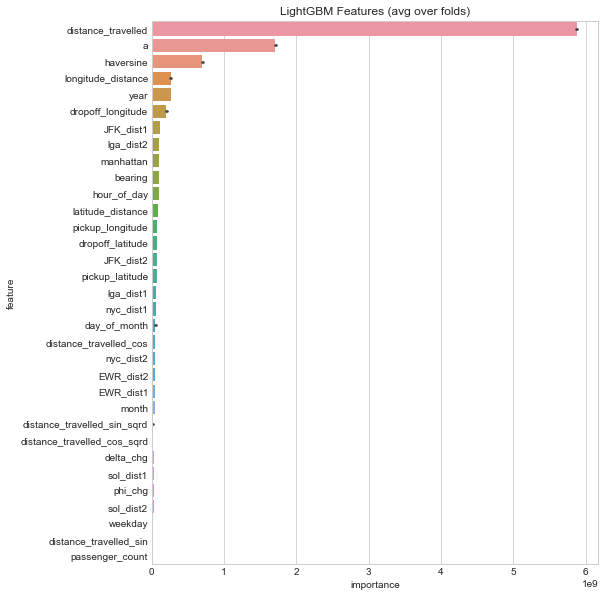

In [33]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout
plt.show()

In [34]:
# bayesian optimization
from bayes_opt import BayesianOptimization

In [35]:
feats = [f for f in train.columns if f not in ['key','pickup_datetime','fare_amount']]
X=train[feats]
y=train['fare_amount']

In [36]:
def bayes_parameter_opt_lgb(X, y, init_round=2, opt_round=8, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.03, output_process=True):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y,free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, colsample_bytree, subsample, max_depth, reg_lambda, reg_alpha, min_split_gain, min_child_weight, 
                min_child_sample, max_bin, subsample_freq):
        params = {'objective':'regression','boosting_type': 'gbdt','nthread': 4, 'verbose': -1,\
                  'num_boost_round': n_estimators, 'learning_rate':learning_rate, \
                  'early_stopping_round':125}
        params['subsample_freq']=int(round(subsample_freq))
        params['min_child_sample']=int(round(min_child_sample))
        params['max_bin']=int(round(max_bin))
        params["num_leaves"] = int(round(num_leaves))
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['subsample'] = max(min(subsample, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['reg_lambda'] = max(reg_lambda, 0)
        params['reg_alpha'] = max(reg_alpha, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=False, verbose_eval=500, metrics=['rmse'])
        return -1.0 * np.mean(cv_result['rmse-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (20, 100),
                                            'colsample_bytree': (0.6, 1.0),
                                            'subsample': (0.6, 1.0),
                                            'max_depth': (-1, 8),
                                            'reg_lambda': (0, 1),
                                            'reg_alpha': (0, 1),
                                            'min_child_sample':(20,100),
                                            'max_bin':(180,500),
                                            'subsample_freq':(1,10),
                                            'min_split_gain': (0.1, 0.8),
                                            'min_child_weight': (3, 20)})
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    #return lgbBO.res['max']['max_params']

opt_params = bayes_parameter_opt_lgb(X, y, init_round=2, opt_round=8, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.03,output_process=True)

Initialization
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   max_bin |   max_depth |   min_child_sample |   min_child_weight |   min_split_gain |   num_leaves |   reg_alpha |   reg_lambda |   subsample |   subsample_freq | 
[500]	cv_agg's rmse: 3.68533 + 0.0138562
[1000]	cv_agg's rmse: 3.61117 + 0.0142965
[1500]	cv_agg's rmse: 3.57979 + 0.0131327
[2000]	cv_agg's rmse: 3.56313 + 0.0127038
[2500]	cv_agg's rmse: 3.55276 + 0.0127025
[3000]	cv_agg's rmse: 3.54616 + 0.012645
[3500]	cv_agg's rmse: 3.54105 + 0.0118931
[4000]	cv_agg's rmse: 3.53806 + 0.0121631
[4500]	cv_agg's rmse: 3.53601 + 0.0123479
[5000]	cv_agg's rmse: 3.53429 + 0.012371
[5500]	cv_agg's rmse: 3.53259 + 0.0125989
[6000]	cv_agg's rmse: 3.53122 + 0.0126505
[6500]	cv_agg's rmse: 3.53039 + 0.0129022
[7000]	cv_a

[10000]	cv_agg's rmse: 3.81495 + 0.0101128
    9 | 177m01s |   -3.93188 |             0.9724 |  496.4249 |      1.7749 |            99.5142 |             9.4332 |           0.6684 |      99.6368 |      0.8595 |       0.5500 |      0.7190 |           1.2726 | 
[500]	cv_agg's rmse: 3.75403 + 0.0111955
[1000]	cv_agg's rmse: 3.6741 + 0.0118993
[1500]	cv_agg's rmse: 3.63257 + 0.0119815
[2000]	cv_agg's rmse: 3.60672 + 0.0117218
[2500]	cv_agg's rmse: 3.58862 + 0.0110668
[3000]	cv_agg's rmse: 3.57574 + 0.0106378
[3500]	cv_agg's rmse: 3.56579 + 0.0106805
[4000]	cv_agg's rmse: 3.55798 + 0.0102316
[4500]	cv_agg's rmse: 3.55153 + 0.0103738
[5000]	cv_agg's rmse: 3.5459 + 0.00990098
[5500]	cv_agg's rmse: 3.54158 + 0.0097807
[6000]	cv_agg's rmse: 3.53763 + 0.00999775
[6500]	cv_agg's rmse: 3.53428 + 0.00999229
[7000]	cv_agg's rmse: 3.53137 + 0.0103535
[7500]	cv_agg's rmse: 3.52838 + 0.0104845
[8000]	cv_agg's rmse: 3.52616 + 0.0104645
[8500]	cv_agg's rmse: 3.52425 + 0.0107235
[9000]	cv_agg's rmse: 3.52

In [37]:
folds = KFold(n_splits=5, shuffle=True, random_state=3560)
# Create arrays and dataframes to store results
oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[feats], train['fare_amount'])):
    dtrain = lgb.Dataset(data=train[feats].iloc[train_idx], 
                         label=train['fare_amount'].iloc[train_idx],
                         free_raw_data=False)
    dvalid = lgb.Dataset(data=train[feats].iloc[valid_idx],
                         label=train['fare_amount'].iloc[valid_idx],
                         free_raw_data=False)
    params = {'boosting_type': 'gbdt',
              'objective': 'regression',
              'metric':'rmse',
              'learning_rate': 0.03,
              'num_leaves': 25, 
              'max_depth': 7,  
              'min_child_samples': 36,  
              'max_bin': 333,  
              'subsample': 0.9525,  
              'subsample_freq': 3,  
              'colsample_bytree': 0.6416,  
              'min_split_gain': 0.1421,
              'min_child_weight': 4.0567,
              'reg_lambda':0.3254,
              'reg_alpha': 0.6913,
              'nthread': 8,
              'verbose': -1,}
    
    clf = lgb.train(params, 
                    dtrain, 
                    valid_sets=[dtrain, dvalid], 
                    valid_names=['train','valid'],
                    num_boost_round=20000,
                    early_stopping_rounds=125,
                    verbose_eval=500)

    oof_preds[valid_idx] = clf.predict(train[feats].iloc[valid_idx])
    sub_preds += clf.predict(test[feats]) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d rmse : %.6f' % (n_fold + 1,mean_squared_error(train['fare_amount'].iloc[valid_idx], oof_preds[valid_idx]) ** .5)) 
    del clf, dtrain, dvalid
    gc.collect()

print('Full rmse %.6f' % mean_squared_error(train['fare_amount'], oof_preds)**.5)
# Write submission file and plot feature importance
sub_df = test[['key']].copy()
sub_df['fare_amount'] = sub_preds
sub_df[['key', 'fare_amount']].to_csv('submission_lgb_bayesian.csv', index= False)

Training until validation scores don't improve for 125 rounds.
[500]	train's rmse: 3.70897	valid's rmse: 3.69911
[1000]	train's rmse: 3.61381	valid's rmse: 3.62497
[1500]	train's rmse: 3.5556	valid's rmse: 3.5854
[2000]	train's rmse: 3.51641	valid's rmse: 3.56388
[2500]	train's rmse: 3.48306	valid's rmse: 3.54675
[3000]	train's rmse: 3.45714	valid's rmse: 3.53667
[3500]	train's rmse: 3.43469	valid's rmse: 3.52854
[4000]	train's rmse: 3.41461	valid's rmse: 3.52193
[4500]	train's rmse: 3.39639	valid's rmse: 3.51597
[5000]	train's rmse: 3.38079	valid's rmse: 3.51178
[5500]	train's rmse: 3.36549	valid's rmse: 3.50734
[6000]	train's rmse: 3.35162	valid's rmse: 3.50386
[6500]	train's rmse: 3.33888	valid's rmse: 3.50196
[7000]	train's rmse: 3.32631	valid's rmse: 3.49989
[7500]	train's rmse: 3.31458	valid's rmse: 3.49785
[8000]	train's rmse: 3.30329	valid's rmse: 3.49601
[8500]	train's rmse: 3.29275	valid's rmse: 3.49444
[9000]	train's rmse: 3.28255	valid's rmse: 3.49286
Early stopping, best i